In [1]:
%run ../spark-default.py

In [2]:
import builtins as b
from datetime import datetime, timedelta, date
import sys, traceback
from delta.tables import DeltaTable

from scipy.cluster.hierarchy import linkage, dendrogram
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline, PipelineModel

In [3]:
df = spark.table("stage.ciha_step3")

df.printSchema()

root
 |-- pk: string (nullable = true)
 |-- mes_cmpt: string (nullable = true)
 |-- espec: string (nullable = true)
 |-- cgc_hosp: string (nullable = true)
 |-- munic_res: string (nullable = true)
 |-- nasc: date (nullable = true)
 |-- sexo: string (nullable = true)
 |-- uti_mes_to: string (nullable = true)
 |-- uti_int_to: string (nullable = true)
 |-- proc_rea: string (nullable = true)
 |-- qt_proc: string (nullable = true)
 |-- dt_atend: date (nullable = true)
 |-- dt_atend_dow: integer (nullable = true)
 |-- dt_saida: date (nullable = true)
 |-- diag_princ: string (nullable = true)
 |-- diag_secun: string (nullable = true)
 |-- cobranca: string (nullable = true)
 |-- natureza: string (nullable = true)
 |-- gestao: string (nullable = true)
 |-- munic_mov: string (nullable = true)
 |-- cod_idade: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- dias_perm: string (nullable = true)
 |-- morte: string (nullable = true)
 |-- nacional: string (nullable = true)
 |-- car_i

In [4]:
df.limit(5)

pk,mes_cmpt,espec,cgc_hosp,munic_res,nasc,sexo,uti_mes_to,uti_int_to,proc_rea,qt_proc,dt_atend,dt_atend_dow,dt_saida,diag_princ,diag_secun,cobranca,natureza,gestao,munic_mov,cod_idade,idade,dias_perm,morte,nacional,car_int,homonimo,cnes,fonte,cgc_consor,modalidade,input_file_name,arquivo_sigla_uf,ano_cmpt,feriado,feriados,feriados_prox,feriados_prox_dist,munic_res_nome_uf,munic_mov_nome_uf,munic_res_nome_municipio,munic_mov_nome_municipio,munic_res_sigla_uf,munic_mov_sigla_uf,munic_res_regiao,munic_mov_regiao,munic_res_populacao_residente,munic_mov_populacao_residente,munic_res_area_unidade_territorial,munic_mov_area_unidade_territorial,diag_princ_sub_categoria,diag_princ_sub_categoria_classificacao,diag_princ_restringido_sexo,diag_princ_causa_obito,diag_princ_sub_categoria_descricao,diag_princ_sub_categoria_descricao_abreviada,diag_princ_sub_categoria_referencia,diag_princ_sub_categoria_excluidos,diag_princ_categoria,diag_princ_categoria_classificacao,diag_princ_categoria_descricao,diag_princ_categoria_descricao_abreviada,diag_princ_categoria_referencia,diag_princ_capitulo_numero,diag_princ_capitulo_descricao,diag_princ_capitulo_descricao_abreviada,diag_secun_sub_categoria,diag_secun_sub_categoria_classificacao,diag_secun_restringido_sexo,diag_secun_causa_obito,diag_secun_sub_categoria_descricao,diag_secun_sub_categoria_descricao_abreviada,diag_secun_sub_categoria_referencia,diag_secun_sub_categoria_excluidos,diag_secun_categoria,diag_secun_categoria_classificacao,diag_secun_categoria_descricao,diag_secun_categoria_descricao_abreviada,diag_secun_categoria_referencia,diag_secun_capitulo_numero,diag_secun_capitulo_descricao,diag_secun_capitulo_descricao_abreviada,munic_res_idhm,munic_mov_idhm,proc_nome,proc_tp_complexidade,proc_tp_sexo,proc_qt_max_exec,proc_qt_dias_perm,proc_qt_pontos,proc_ds_procedimento,proc_no_grupo,proc_no_sub_grupo,proc_no_forma_organizacao
f8292abf-4df3-491...,06,null,60961422000155,355030,2019-04-08,3,0,000,0301010072,1,2024-06-20,5,2024-06-20,J039,null,18,null,M,355030,4,05,0,0,null,null,null,2089602,01,00000000000000,01,s3a://datalake/so...,SP,2024,false,null,"[{2024-05-30, Cor...",19,São Paulo,São Paulo,São Paulo,São Paulo,SP,SP,Sudeste,Sudeste,11253503,11253503,1521.101,1521.101,J039,null,null,null,Amigdalite aguda ...,J03.9 Amigdalite ...,null,null,J03,null,Amigdalite aguda,J03 Amigdalite ...,null,10,Capítulo X - Doen...,X. Doenças do a...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.805,0.805,CONSULTA MEDICA E...,2,I,9999,9999,0000,CONSULTA CLÍNICA ...,Procedimentos clí...,Tratamentos clíni...,Tratamento de doe...
8ba519f8-620f-4bb...,11,null,44215341000150,350330,1973-02-15,3,0,000,0204030030,1,2024-11-11,2,2024-11-11,Z016,null,18,null,M,350330,4,51,0,0,null,null,null,2081253,01,00000000000000,01,s3a://datalake/so...,SP,2024,false,null,"[{2024-11-20, Dia...",4,São Paulo,São Paulo,Araras,Araras,SP,SP,Sudeste,Sudeste,118843,118843,644.831,644.831,Z016,null,null,null,Exame radiológico...,Z01.6 Exame radio...,null,null,Z01,null,Outros exames e i...,Z01 Outr exam i...,null,21,Capítulo XXI - Fa...,XXI. Contatos com...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.781,0.781,MAMOGRAFIA,2,I,0002,9999,0000,EXAME RADIOLÓGICO...,Procedimentos com...,Diagnóstico em la...,Exames hematológi...
16f56e13-42bb-4c7...,04,null,16731630000176,310260,1946-03-07,3,0,000,0206010079,1,2024-04-28,1,2024-04-28,E889,null,18,null,M,310260,4,78,0,0,null,null,null,2775956,01,00000000000000,01,s3a://datalake/so...,MG,2024,false,null,"[{2024-05-01, Dia...",3,Minas Gerais,Minas Gerais,Andradas,Andradas,MG,MG,Sudeste,Sudeste,37270,37270,469.37,469.37,E889,null,null,null,Distúrbio metaból...,E88.9 Disturbio m...,null,null,E88,null,Outros distúrbios...,E88 Outr distur...,null,4,Capítulo IV - Doe...,IV. Doenças endó...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.734,0.734,TOMOGRAFIA COMPUT...,3,I,0002,9999,0000,CONSISTE NO MÉ

In [5]:
df_prep = df.filter(
    col("feriado").isNotNull()
    & col("uti_int_to").cast("integer").isNotNull()
    & col("diag_princ_categoria").isNotNull()
).select(
    col("dt_atend"),
    date_format("dt_atend", "dd").cast("integer").alias("dt_atend_dia"),
    date_format("dt_atend", "MM").cast("integer").alias("dt_atend_mes"),
    date_format("dt_atend", "yyyy").cast("integer").alias("dt_atend_ano"),
    weekofyear("dt_atend").alias("dt_atend_woy"),
    col("nasc"),
    date_format("nasc", "dd").cast("integer").alias("dt_nasc_dia"),
    date_format("nasc", "MM").cast("integer").alias("dt_nasc_mes"),
    date_format("nasc", "yyyy").cast("integer").alias("dt_nasc_ano"),
    weekofyear("nasc").alias("dt_nasc_woy"),
    col("sexo").cast("integer").alias("sexo"),
    col("uti_int_to").cast("integer").alias("uti_int_to"),
    col("qt_proc").cast("integer").alias("qt_proc"),
    col("dt_atend_dow"), # 1 -> Domingo, 7 -> Sabado
    col("dt_saida"),
    date_format("dt_saida", "dd").cast("integer").alias("dt_saida_dia"),
    date_format("dt_saida", "MM").cast("integer").alias("dt_saida_mes"),
    date_format("dt_saida", "yyyy").cast("integer").alias("dt_saida_ano"),
    weekofyear("dt_saida").alias("dt_saida_woy"),
    col("diag_princ"),
    col("idade").cast("integer").alias("idade"),
    col("dias_perm").cast("integer").alias("dias_perm"),
    when(col("feriado") == lit(True), lit(1)).otherwise(lit(0)).alias("feriado"),
    size(col("feriados")).alias("feriados_qtd"),
    size(col("feriados_prox")).alias("feriados_prox_qtd"),
    when(col("feriados_prox_dist").isNull(), lit(30)).otherwise(col("feriados_prox_dist")).alias("feriados_prox_dist"),
    col("munic_res_sigla_uf"),
    col("munic_mov_sigla_uf"),
    col("munic_res_nome_uf"),
    col("munic_mov_nome_uf"),
    col("munic_res_populacao_residente").cast("integer").alias("munic_res_populacao_residente"),
    col("munic_mov_populacao_residente").cast("integer").alias("munic_mov_populacao_residente"),
    col("munic_res_area_unidade_territorial").cast("integer").alias("munic_res_area_unidade_territorial"),
    col("munic_mov_area_unidade_territorial").cast("integer").alias("munic_mov_area_unidade_territorial"),
    col("munic_res_idhm").cast("double").alias("munic_res_idhm"),
    col("munic_mov_idhm").cast("double").alias("munic_mov_idhm"),
    col("diag_princ_categoria"),
    col("diag_princ_capitulo_numero").cast("integer").alias("diag_princ_capitulo_numero"),
    col("proc_rea").cast("integer").alias("proc_rea"),
    col("morte").cast("integer").alias("morte")
)

categoricas_int = [
    "sexo",
    "dt_atend_dow",
    "feriado",
    "diag_princ_capitulo_numero",
    "proc_rea",
    "dt_atend_mes",
    "dt_nasc_mes",
    "dt_saida_mes"
]

categoricas_str = [
    "diag_princ",
    "munic_res_sigla_uf",
    "munic_mov_sigla_uf",
    "munic_res_nome_uf",
    "munic_mov_nome_uf",
    "diag_princ_categoria"
]

categoricas = [
    "sexo",
    "dt_atend_dow",
    "diag_princ",
    "munic_res_sigla_uf",
    "munic_mov_sigla_uf",
    "munic_res_nome_uf",
    "munic_mov_nome_uf",
    "feriado",
    "diag_princ_categoria",
    "diag_princ_capitulo_numero",
    "proc_rea",
    "dt_atend_mes",
    "dt_nasc_mes",
    "dt_saida_mes"
]

numericas = [
    "dt_atend_dia",
    "dt_atend_ano",
    "dt_atend_woy",
    "dt_nasc_dia",
    "dt_nasc_ano",
    "dt_nasc_woy",
    "dt_saida_dia",
    "dt_saida_ano",
    "dt_saida_woy",
    "uti_int_to",
    "qt_proc",
    "idade",
    "dias_perm",
    "feriados_qtd",
    "feriados_prox_qtd",
    "feriados_prox_dist",
    "munic_res_populacao_residente",
    "munic_mov_populacao_residente",
    "munic_res_area_unidade_territorial",
    "munic_mov_area_unidade_territorial",
    "munic_res_idhm",
    "munic_mov_idhm"
]

df_treinamento = df_prep.filter("dt_atend between '2011-01-01' and '2023-12-31'")
df_teste = df_prep.filter("dt_atend between '2024-01-01' and '2024-12-31'")

target_col = 'morte'

In [6]:
df_prep.limit(5)

dt_atend,dt_atend_dia,dt_atend_mes,dt_atend_ano,dt_atend_woy,nasc,dt_nasc_dia,dt_nasc_mes,dt_nasc_ano,dt_nasc_woy,sexo,uti_int_to,qt_proc,dt_atend_dow,dt_saida,dt_saida_dia,dt_saida_mes,dt_saida_ano,dt_saida_woy,diag_princ,idade,dias_perm,feriado,feriados_qtd,feriados_prox_qtd,feriados_prox_dist,munic_res_sigla_uf,munic_mov_sigla_uf,munic_res_nome_uf,munic_mov_nome_uf,munic_res_populacao_residente,munic_mov_populacao_residente,munic_res_area_unidade_territorial,munic_mov_area_unidade_territorial,munic_res_idhm,munic_mov_idhm,diag_princ_categoria,diag_princ_capitulo_numero,proc_rea,morte
2020-07-27,27,7,2020,31,1969-07-31,31,7,1969,31,3,0,1,2,2020-07-27,27,7,2020,31,N778,50,0,0,-1,4,18,SP,SP,São Paulo,São Paulo,43258,43258,488,488,0.776,0.776,N77,14,211040029,0
2020-02-19,19,2,2020,8,1986-08-12,12,8,1986,33,1,0,1,4,2020-02-19,19,2,2020,8,M545,33,0,0,-1,10,30,MG,MG,Minas Gerais,Minas Gerais,57390,57390,470,470,0.717,0.717,M54,13,301060061,0
2020-10-14,14,10,2020,42,1981-09-05,5,9,1981,36,3,0,1,4,2020-10-14,14,10,2020,42,R529,39,0,0,-1,8,2,MG,MG,Minas Gerais,Minas Gerais,10552,109783,597,1253,0.648,0.756,R52,18,301010072,0
2020-10-02,2,10,2020,40,1975-03-12,12,3,1975,11,3,0,1,6,2020-10-02,2,10,2020,40,Z018,45,0,0,-1,8,10,SP,SP,São Paulo,São Paulo,11253503,11253503,1521,1521,0.805,0.805,Z01,21,204030030,0
2020-11-12,12,11,2020,46,1953-05-11,11,5,1953,20,1,0,1,5,2020-11-12,12,11,2020,46,R072,67,0,0,-1,15,3,SP,SP,São Paulo,São Paulo,11253503,11253503,1521,1521,0.805,0.805,R07,18,205010032,0


In [9]:
# Analise nulos

prep_nulls = df_prep.select(count("*").alias("total"), *[count(when(col(c).isNull(), c)).alias(c) for c in df_prep.columns]).first().asDict()

prep_nulls_total = prep_nulls["total"]

df_prep_nulls = spark.createDataFrame(
    [{"col": k, "count": v, "percentual": b.round((v/prep_nulls_total) * 100, 2)} for k,v in prep_nulls.items()]
) #.orderBy(col("count").desc())

df_prep_nulls.show(200, truncate=False)

+----------------------------------+---------+----------+
|col                               |count    |percentual|
+----------------------------------+---------+----------+
|total                             |124513800|100.0     |
|dt_atend                          |0        |0.0       |
|dt_atend_dia                      |0        |0.0       |
|dt_atend_mes                      |0        |0.0       |
|dt_atend_ano                      |0        |0.0       |
|dt_atend_woy                      |0        |0.0       |
|nasc                              |0        |0.0       |
|dt_nasc_dia                       |0        |0.0       |
|dt_nasc_mes                       |0        |0.0       |
|dt_nasc_ano                       |0        |0.0       |
|dt_nasc_woy                       |0        |0.0       |
|sexo                              |0        |0.0       |
|uti_int_to                        |0        |0.0       |
|qt_proc                           |0        |0.0       |
|dt_atend_dow 

In [29]:
df_prep.printSchema()

root
 |-- dt_atend: date (nullable = true)
 |-- dt_atend_dia: integer (nullable = true)
 |-- dt_atend_mes: integer (nullable = true)
 |-- dt_atend_ano: integer (nullable = true)
 |-- dt_atend_woy: integer (nullable = true)
 |-- nasc: date (nullable = true)
 |-- dt_nasc_dia: integer (nullable = true)
 |-- dt_nasc_mes: integer (nullable = true)
 |-- dt_nasc_ano: integer (nullable = true)
 |-- dt_nasc_woy: integer (nullable = true)
 |-- sexo: integer (nullable = true)
 |-- uti_int_to: integer (nullable = true)
 |-- qt_proc: integer (nullable = true)
 |-- dt_atend_dow: integer (nullable = true)
 |-- dt_saida: date (nullable = true)
 |-- dt_saida_dia: integer (nullable = true)
 |-- dt_saida_mes: integer (nullable = true)
 |-- dt_saida_ano: integer (nullable = true)
 |-- dt_saida_woy: integer (nullable = true)
 |-- diag_princ: string (nullable = true)
 |-- idade: integer (nullable = true)
 |-- dias_perm: integer (nullable = true)
 |-- feriado: integer (nullable = false)
 |-- feriados_qtd: in

In [7]:
from pyspark.ml.feature import StringIndexer

df_prep_corrigido = df_prep.select(
    *numericas,
    *categoricas_int,
    *categoricas_str,
    target_col
)

for c in categoricas_str:
    print(c)
    indexer = StringIndexer(inputCol=c, outputCol=c + "_index")
    df_prep_corrigido = indexer.fit(df_prep_corrigido).transform(df_prep_corrigido)

df_prep_corrigido = df_prep_corrigido.select(
    *numericas,
    *categoricas_int,
    *[col(x + "_index").alias(x) for x in categoricas_str],
    target_col
)

diag_princ
munic_res_sigla_uf
munic_mov_sigla_uf
munic_res_nome_uf
munic_mov_nome_uf
diag_princ_categoria


In [8]:
df_prep_corrigido.printSchema()

root
 |-- dt_atend_dia: integer (nullable = true)
 |-- dt_atend_ano: integer (nullable = true)
 |-- dt_atend_woy: integer (nullable = true)
 |-- dt_nasc_dia: integer (nullable = true)
 |-- dt_nasc_ano: integer (nullable = true)
 |-- dt_nasc_woy: integer (nullable = true)
 |-- dt_saida_dia: integer (nullable = true)
 |-- dt_saida_ano: integer (nullable = true)
 |-- dt_saida_woy: integer (nullable = true)
 |-- uti_int_to: integer (nullable = true)
 |-- qt_proc: integer (nullable = true)
 |-- idade: integer (nullable = true)
 |-- dias_perm: integer (nullable = true)
 |-- feriados_qtd: integer (nullable = false)
 |-- feriados_prox_qtd: integer (nullable = false)
 |-- feriados_prox_dist: integer (nullable = true)
 |-- munic_res_populacao_residente: integer (nullable = true)
 |-- munic_mov_populacao_residente: integer (nullable = true)
 |-- munic_res_area_unidade_territorial: integer (nullable = true)
 |-- munic_mov_area_unidade_territorial: integer (nullable = true)
 |-- munic_res_idhm: dou

In [9]:
df_prep_corrigido.limit(5)

dt_atend_dia,dt_atend_ano,dt_atend_woy,dt_nasc_dia,dt_nasc_ano,dt_nasc_woy,dt_saida_dia,dt_saida_ano,dt_saida_woy,uti_int_to,qt_proc,idade,dias_perm,feriados_qtd,feriados_prox_qtd,feriados_prox_dist,munic_res_populacao_residente,munic_mov_populacao_residente,munic_res_area_unidade_territorial,munic_mov_area_unidade_territorial,munic_res_idhm,munic_mov_idhm,sexo,dt_atend_dow,feriado,diag_princ_capitulo_numero,proc_rea,dt_atend_mes,dt_nasc_mes,dt_saida_mes,diag_princ,munic_res_sigla_uf,munic_mov_sigla_uf,munic_res_nome_uf,munic_mov_nome_uf,diag_princ_categoria,morte
27,2020,31,31,1969,31,27,2020,31,0,1,50,0,-1,4,18,43258,43258,488,488,0.776,0.776,3,2,0,14,211040029,7,7,7,1784.0,0.0,0.0,0.0,0.0,593.0,0
19,2020,8,12,1986,33,19,2020,8,0,1,33,0,-1,10,30,57390,57390,470,470,0.717,0.717,1,4,0,13,301060061,2,8,2,6.0,2.0,2.0,2.0,2.0,3.0,0
14,2020,42,5,1981,36,14,2020,42,0,1,39,0,-1,8,2,10552,109783,597,1253,0.648,0.756,3,4,0,18,301010072,10,9,10,17.0,2.0,2.0,2.0,2.0,4.0,0
2,2020,40,12,1975,11,2,2020,40,0,1,45,0,-1,8,10,11253503,11253503,1521,1521,0.805,0.805,3,6,0,21,204030030,10,3,10,1.0,0.0,0.0,0.0,0.0,1.0,0
12,2020,46,11,1953,20,12,2020,46,0,1,67,0,-1,15,3,11253503,11253503,1521,1521,0.805,0.805,1,5,0,18,205010032,11,5,11,115.0,0.0,0.0,0.0,0.0,25.0,0


In [10]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

colunas_para_correlacao = [
    *numericas,
    *categoricas_int,
    *categoricas_str,
    target_col
]

assembler = VectorAssembler(inputCols=colunas_para_correlacao, outputCol="features")
df_vector = assembler.transform(df_prep_corrigido)

correlation_matrix = Correlation.corr(df_vector, "features", "pearson").head()[0]

In [11]:
corr_np = correlation_matrix.toArray()
corr_df = pd.DataFrame(corr_np, index=colunas_para_correlacao, columns=colunas_para_correlacao)

corr_com_morte = corr_df[target_col].drop(target_col)
corr_com_morte = corr_com_morte.reindex(corr_com_morte.abs().sort_values(ascending=False).index)

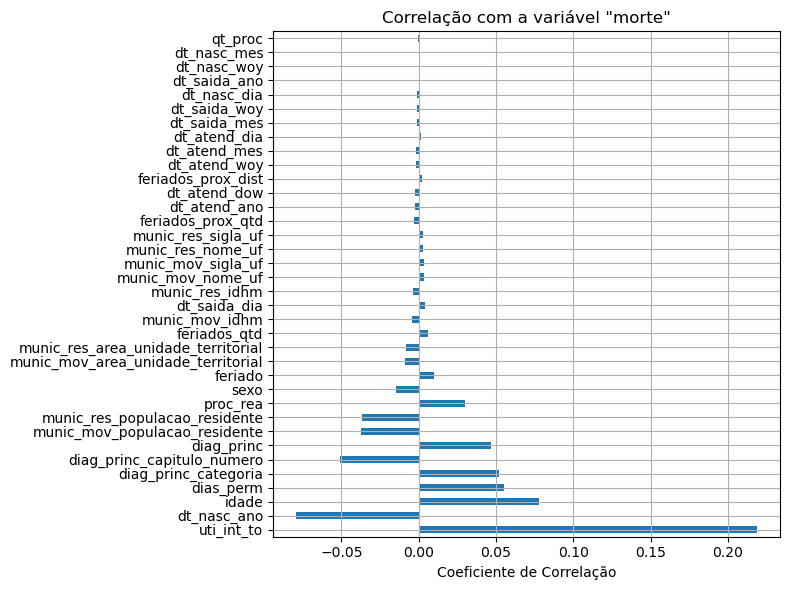

In [13]:
corr_com_morte.plot(kind='barh', figsize=(8, 6))
plt.title('Correlação com a variável "morte"')
plt.xlabel('Coeficiente de Correlação')
plt.grid(True)
plt.tight_layout()
plt.savefig("correlacao.png", dpi=300)
plt.show()

In [38]:
spark.stop()